# Titanic – Data Profiling (Single-Column, Multi-Column & Dependencies)

Este notebook guía un **perfilado completo** para el dataset *Titanic – Machine Learning from Disaster* (Kaggle).  
Incluye tres bloques:

1) **Single-Column Profiling** (univariado)  
2) **Multi-Column Profiling** (relaciones entre columnas)  
3) **Dependencies Profiling** (reglas/relaciones implícitas)



## 0. Setup y carga de datos

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv("Titanic-Dataset.csv")

In [ ]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 1) Single-Column Profiling (univariado)

**Objetivo:** Comprender cada atributo por separado para detectar nulos, valores inusuales, cardinalidad, patrones y el dominio efectivo.



In [ ]:
def single_column_profile(dataframe: pd.DataFrame) -> pd.DataFrame:
    prof = []
    for col in dataframe.columns:
        s = dataframe[col]
        dtype = s.dtype
        n = len(s)
        non_null = s.notna().sum()
        nulls = s.isna().sum()
        null_pct = round(nulls * 100.0 / n, 2)
        unique = s.nunique(dropna=True)
        sample_vals = s.dropna().astype(str).value_counts().head(3).index.tolist()
        prof.append({
            "column": col, "dtype": str(dtype), "count": n, "non_null": non_null,
            "nulls": nulls, "null_%": null_pct, "unique": unique, "top_examples": sample_vals
        })
    return pd.DataFrame(prof).sort_values(by=["null_%","unique"], ascending=[False, True])

profile_sc = single_column_profile(df)
profile_sc


,column,dtype,count,non_null,nulls,null_%,unique,top_examples
10,Cabin,object,891,204,687,77.10,147,"[G6, C23 C25 C27, B96 B98]"
5,Age,float64,891,714,177,19.87,88,"[24.0, 22.0, 18.0]"
11,Embarked,object,891,889,2,0.22,3,"[S, C, Q]"
1,Survived,int64,891,891,0,0.00,2,"[0, 1]"
4,Sex,object,891,891,0,0.00,2,"[male, female]"
2,Pclass,int64,891,891,0,0.00,3,"[3, 1, 2]"
6,SibSp,int64,891,891,0,0.00,7,"[0, 1, 2]"
7,Parch,int64,891,891,0,0.00,7,"[0, 1, 2]"
9,Fare,float64,891,891,0,0.00,248,"[8.05, 13.0, 7.8958]"
8,Ticket,object,891,891,0,0.00,681,"[347082, 1601, CA. 2343]"


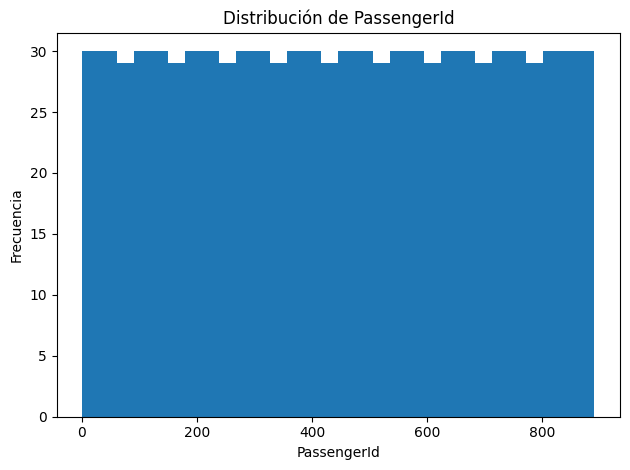

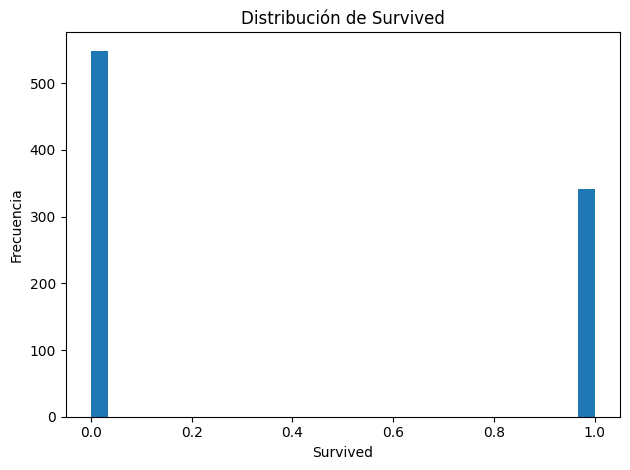

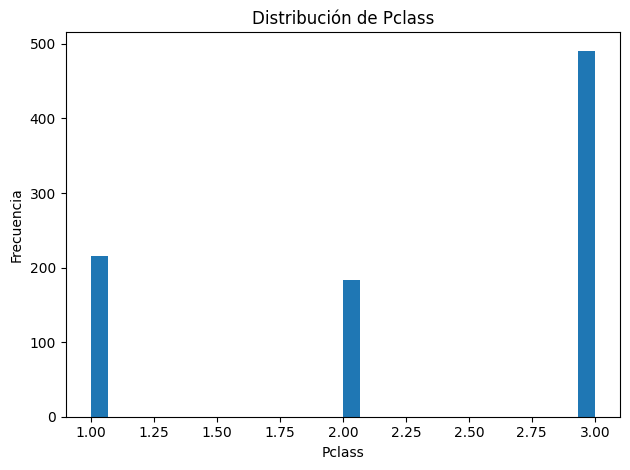

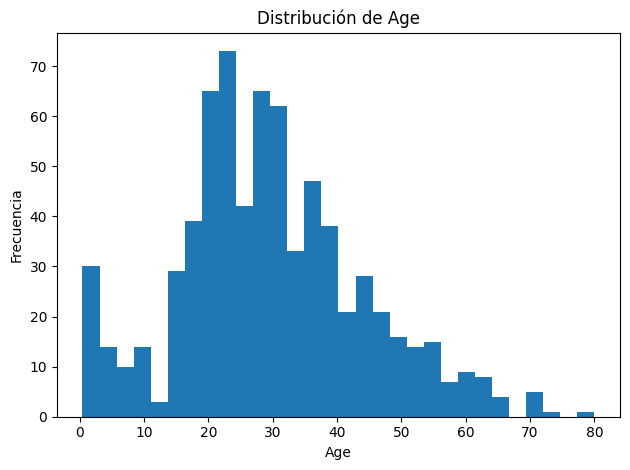

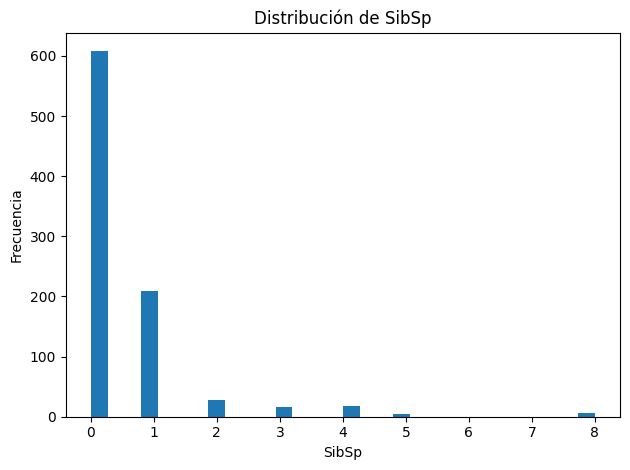

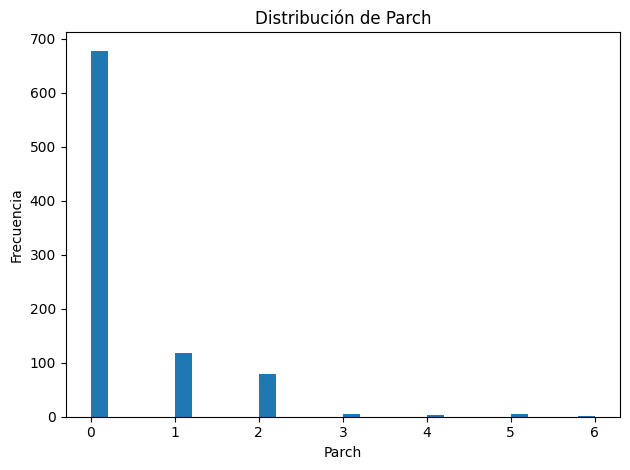

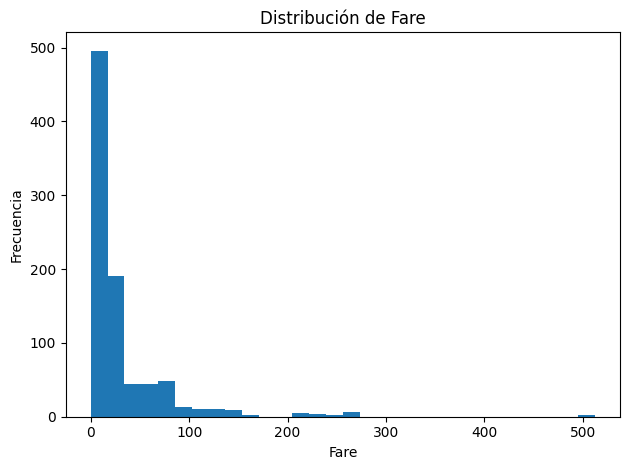

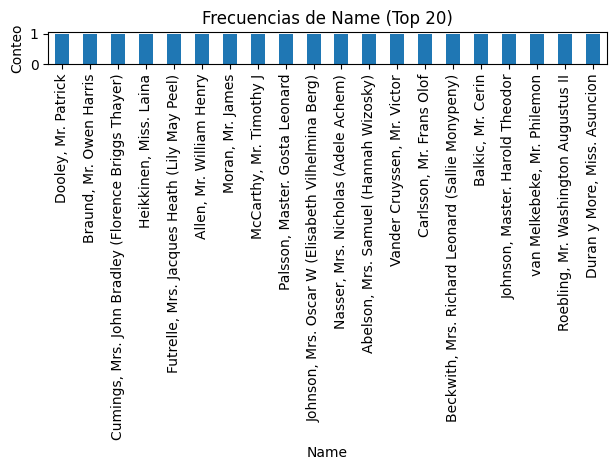

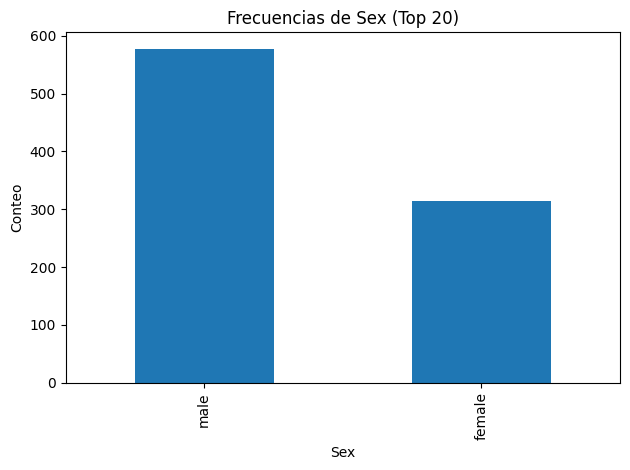

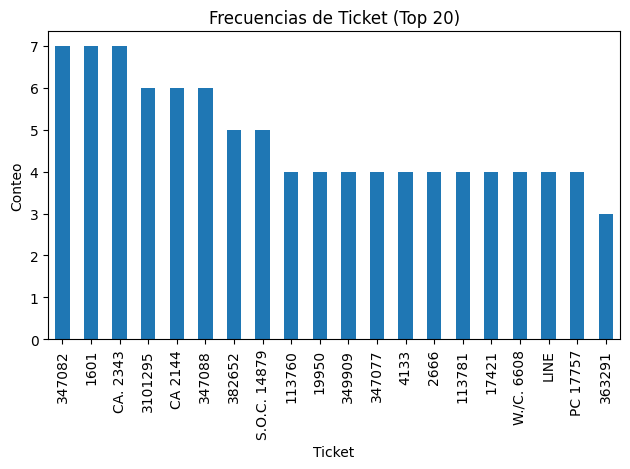

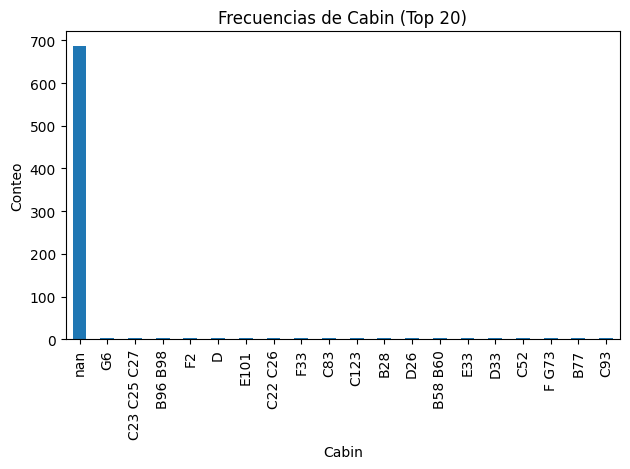

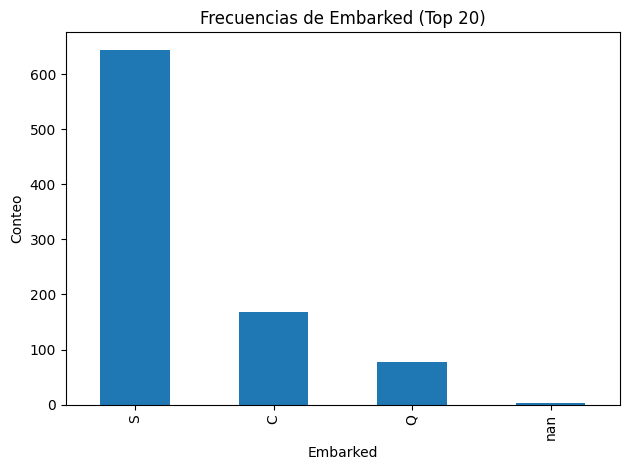

In [ ]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

for col in numeric_cols:
    plt.figure()
    df[col].plot(kind="hist", bins=30)
    plt.title(f"Distribución de {col}")
    plt.xlabel(col); plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()

for col in categorical_cols:
    plt.figure()
    df[col].astype(str).value_counts().head(20).plot(kind="bar")
    plt.title(f"Frecuencias de {col} (Top 20)")
    plt.xlabel(col); plt.ylabel("Conteo")
    plt.tight_layout()
    plt.show()

## 2) Multi-Column Profiling

**Objetivo:** analizar el comportamiento conjunto de varias columnas para hallar **correlaciones**, **asociaciones**, **clusters** y **outliers**.

Incluye:
- **Correlaciones** (variables numéricas).
- **Asociaciones** con `Survived` (tablas de contingencia).
- **Scatter** `Age` vs `Fare`.
- **Outliers** Box Plots


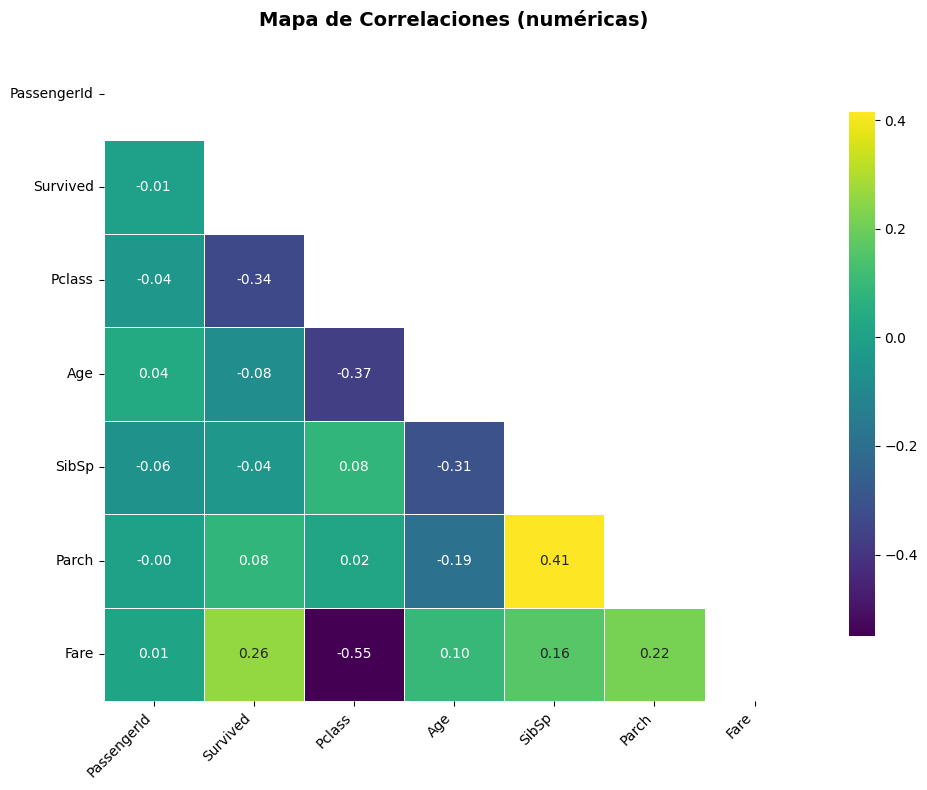

In [ ]:
# 2.1 Correlaciones numéricas (heatmap con máscara inferior)
corr = df[numeric_cols].corr(numeric_only=True)

# Crear una máscara para el triángulo superior
mask = np.triu(np.ones_like(corr, dtype=bool))

# Configurar el tamaño de la figura
plt.figure(figsize=(10, 8))

# Dibujar el heatmap con la máscara
sns.heatmap(
    corr,
    mask=mask,
    cmap="viridis",
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)

plt.title("Mapa de Correlaciones (numéricas)", fontsize=14, fontweight="bold", pad=15)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
# 2.2 Asociaciones simples con la variable objetivo
ct_sex = pd.crosstab(df["Sex"], df["Survived"], normalize="index").round(3)
ct_pclass = pd.crosstab(df["Pclass"], df["Survived"], normalize="index").round(3)

display(ct_sex); display(ct_pclass)

Survived,0,1
Sex,,
female,0.258,0.742
male,0.811,0.189


Survived,0,1
Pclass,,
1,0.370,0.630
2,0.527,0.473
3,0.758,0.242


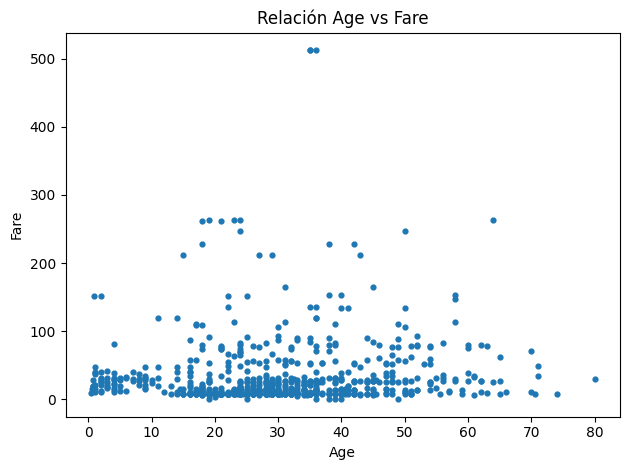

In [ ]:
# 2.3 Relación Age vs Fare (removiendo nulos)
if {"Age","Fare"}.issubset(df.columns):
    tmp = df[["Age","Fare","Survived"]].dropna()
    plt.figure()
    plt.scatter(tmp["Age"], tmp["Fare"], s=12)
    plt.title("Relación Age vs Fare")
    plt.xlabel("Age"); plt.ylabel("Fare")
    plt.tight_layout()
    plt.show()

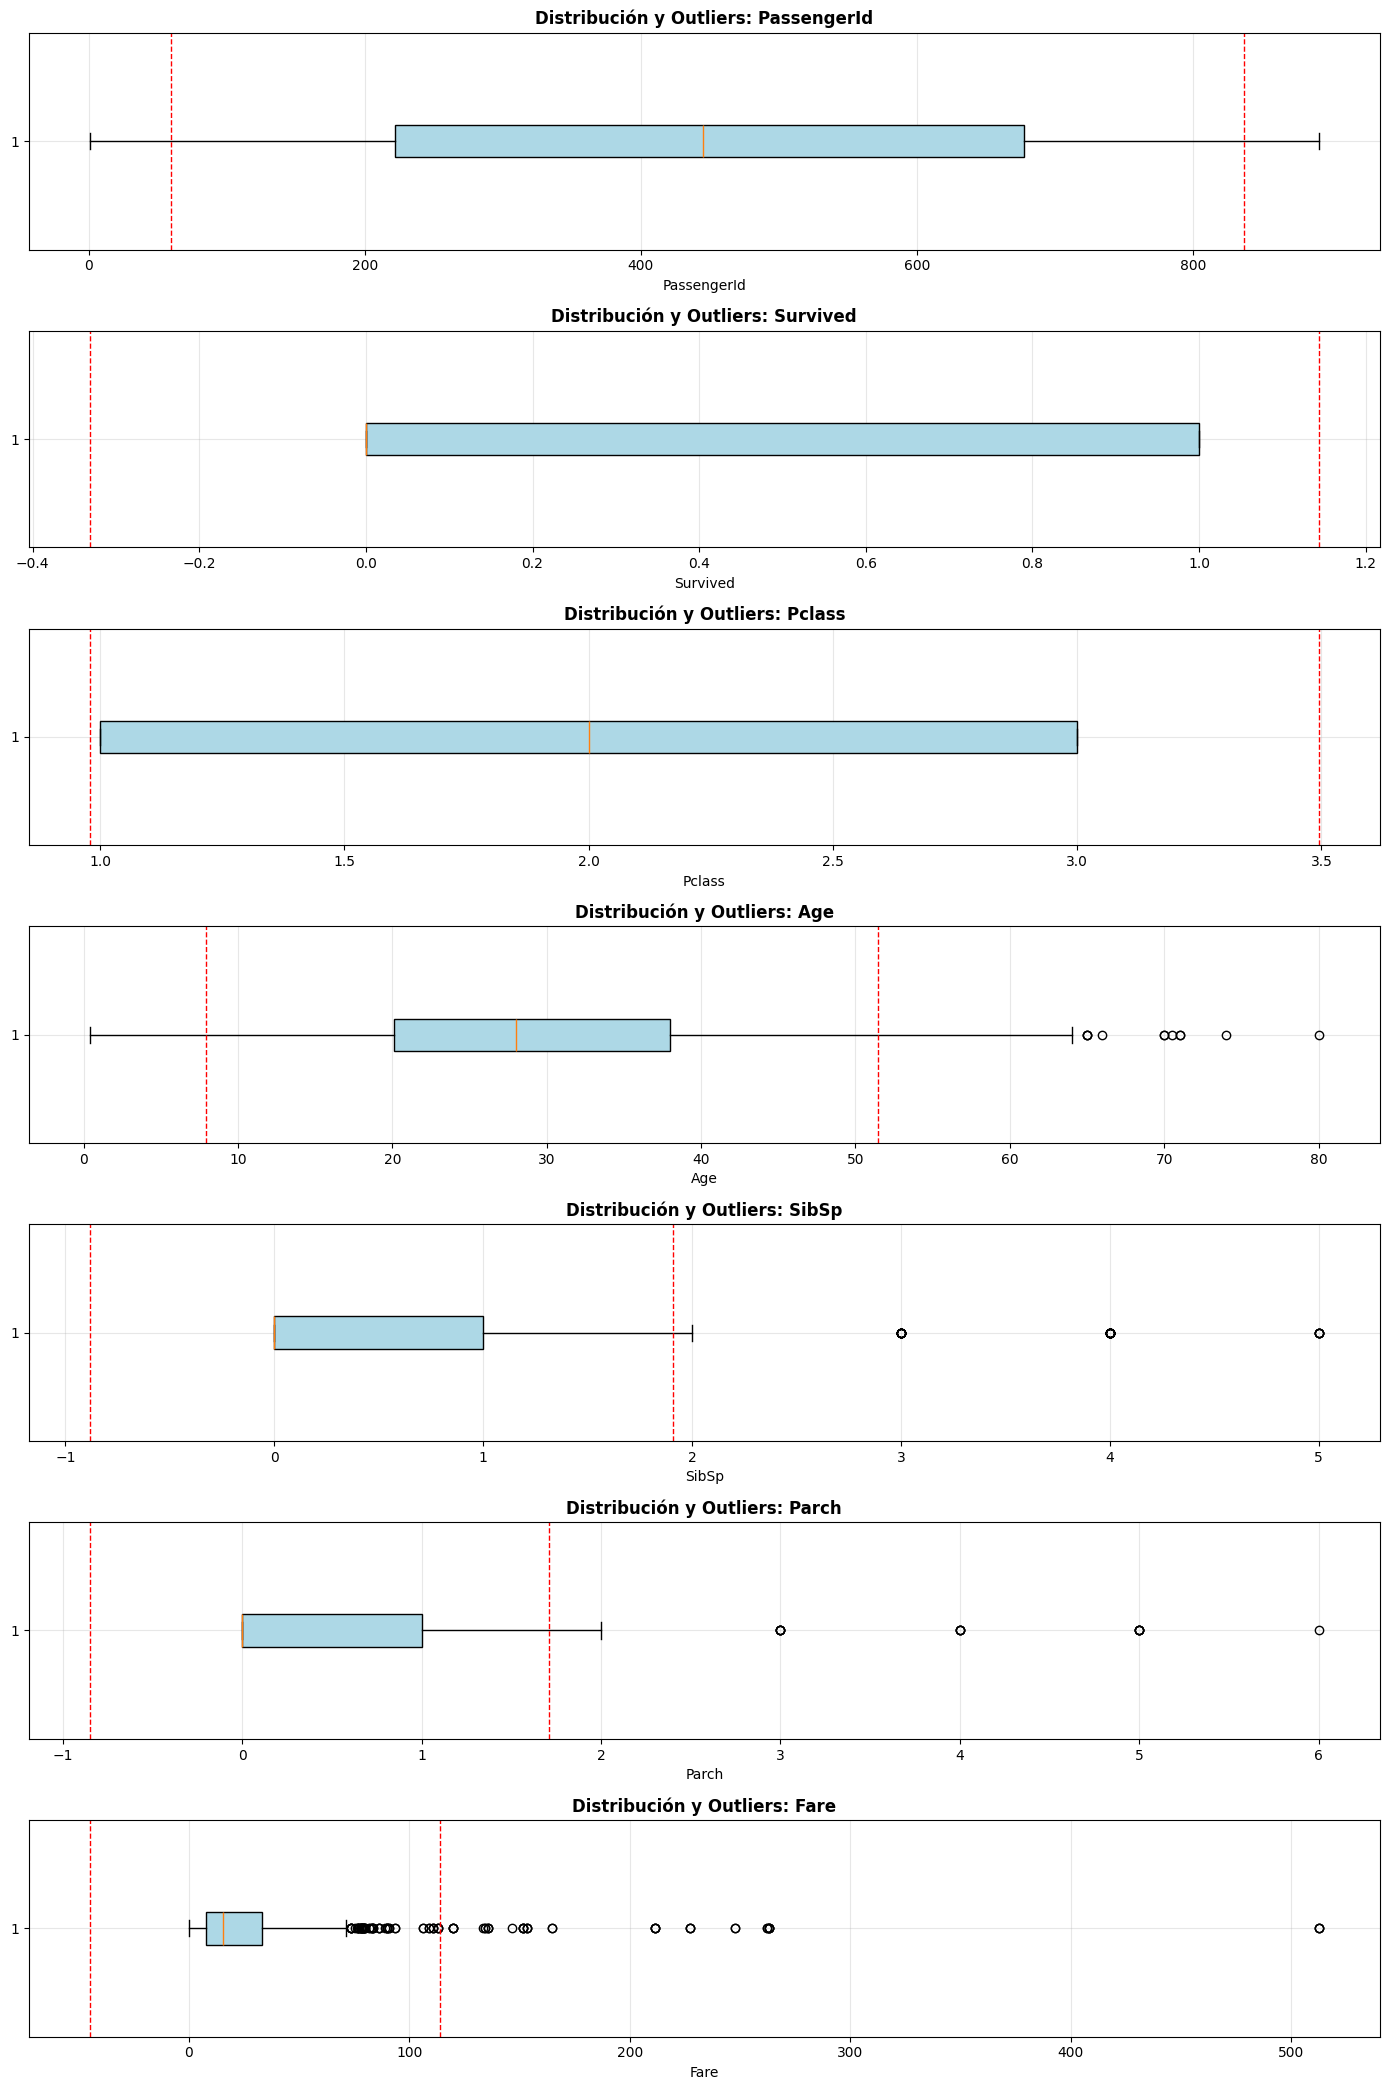

Resumen de Outliers (basado en 1.5 desviaciones estándar):


,mean,std,lower_bound,upper_bound,outliers_count,outlier_ratio
PassengerId,448.583,259.120,59.903,837.262,89.0,0.1246
Survived,0.406,0.491,-0.331,1.143,0.0,0.0000
Pclass,2.237,0.838,0.979,3.494,0.0,0.0000
Age,29.699,14.526,7.909,51.489,107.0,0.1499
SibSp,0.513,0.930,-0.882,1.907,60.0,0.0840
Parch,0.431,0.853,-0.849,1.711,83.0,0.1162
Fare,34.695,52.919,-44.684,114.073,38.0,0.0532


In [ ]:
# 2.4 Outliers univariados usando regla de 1.5 desviaciones estándar
num_for_outliers = df[numeric_cols].dropna()

outlier_summary = {}

plt.figure(figsize=(14, len(num_for_outliers.columns) * 3))

for i, col in enumerate(num_for_outliers.columns, 1):
    data = num_for_outliers[col]

    mean = data.mean()
    std = data.std()

    # Definimos umbrales
    lower_bound = mean - 1.5 * std
    upper_bound = mean + 1.5 * std

    # Identificamos outliers
    outliers = data[(data < lower_bound) | (data > upper_bound)]

    # Guardamos estadísticas
    outlier_summary[col] = {
        "mean": round(mean, 3),
        "std": round(std, 3),
        "lower_bound": round(lower_bound, 3),
        "upper_bound": round(upper_bound, 3),
        "outliers_count": len(outliers),
        "outlier_ratio": round(len(outliers) / len(data), 4)
    }

    # --- Gráfico ---
    plt.subplot(len(num_for_outliers.columns), 1, i)
    plt.boxplot(data, vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
    plt.axvline(lower_bound, color='red', linestyle='--', linewidth=1)
    plt.axvline(upper_bound, color='red', linestyle='--', linewidth=1)
    plt.title(f"Distribución y Outliers: {col}", fontsize=12, fontweight='bold')
    plt.xlabel(col)
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Mostrar resumen tabular
outlier_df = pd.DataFrame(outlier_summary).T
print("Resumen de Outliers (basado en 1.5 desviaciones estándar):")
display(outlier_df)

## 3) Dependencies Profiling

**Objetivo:** descubrir y/o validar **reglas implícitas** en los datos:
- **Unicidad / claves candidatas**  
- **Dependencias funcionales** (FD)  
- **Dependencias de inclusión** (IND)  
- **Dependencias condicionales aproximadas** (CFD-like)

> Aquí usamos **heurísticas simples** para ilustrar los conceptos (no equivalen a algoritmos exhaustivos de descubrimiento).


In [ ]:
# 3.1 Candidatas a clave (unicidad por columna)
uniqueness = []
for col in df.columns:
    unique_ratio = df[col].nunique(dropna=True) / len(df)
    uniqueness.append({"column": col, "unique_ratio": round(float(unique_ratio), 4)})
pd.DataFrame(uniqueness).sort_values("unique_ratio", ascending=False)

,column,unique_ratio
0,PassengerId,1.0000
3,Name,1.0000
8,Ticket,0.7643
9,Fare,0.2783
10,Cabin,0.1650
5,Age,0.0988
6,SibSp,0.0079
7,Parch,0.0079
11,Embarked,0.0034
2,Pclass,0.0034


## 4) Conclusiones y siguientes pasos

- El **Single-Column Profiling** da la fotografía base (nulos, cardinalidad, patrones).  
- El **Multi-Column Profiling** revela relaciones, asociaciones y comportamientos conjuntos.  
- El **Dependencies Profiling** permite formalizar **reglas** que luego pueden traducirse en **validaciones**